In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_data=pd.read_csv('/sales_train.csv')
test_data=pd.read_csv('/test.csv')

In [ ]:
train_data.shape

(2935849, 6)

In [ ]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
train_data.info()
train_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [ ]:
#eksik değer kontrolü
train_data.isnull().sum()

,0
date,0
date_block_num,0
shop_id,0
item_id,0
item_price,0
item_cnt_day,0


In [ ]:
# datetime formatına çevirme
train_data['date'] = pd.to_datetime(train_data['date'],format='%d.%m.%Y')

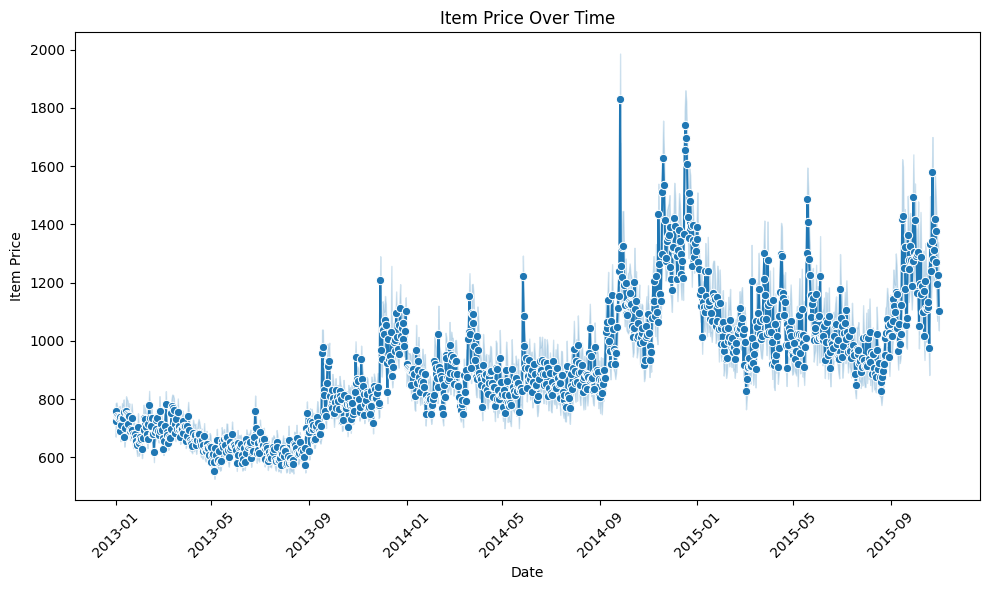

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(data=train_data, x='date', y='item_price', marker='o')
plt.title('Item Price Over Time')
plt.xlabel('Date')
plt.ylabel('Item Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Veri Önişleme

In [ ]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [ ]:
# Date' sütunundan ek özellikler çıkarılması
train_data['Year'] = train_data['date'].dt.year
train_data['Month'] =train_data['date'].dt.month
train_data['Day'] = train_data['date'].dt.day
train_data['Day_of_Week'] =train_data['date'].dt.day_name()

In [ ]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Year,Month,Day,Day_of_Week
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2,Wednesday
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,3,Thursday
2,2013-01-05,0,25,2552,899.00,-1.0,2013,1,5,Saturday
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,6,Sunday
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15,Tuesday


In [ ]:
# satırdaki negatif değerleri silme
train_data= train_data[train_data['item_cnt_day'] >= 0]

In [ ]:
categorical_cols = ['Day_of_Week']

for col in categorical_cols:
    le=LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])

In [ ]:

z_scores = stats.zscore(train_data.select_dtypes(include=['float64', 'int64']))  # Only for numeric columns
abs_z_scores = abs(z_scores)

#eşik değeri belirleme (genellikle 3 veya -3)
threshold = 2
train_data = train_data[(abs_z_scores < threshold).all(axis=1)]  # Remove rows where any column has outlier

In [ ]:
train_data.shape

(2855775, 10)

#Model Oluşturma

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
#LSTM için veri kümesi oluşturma fonksiyonu
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

# Veri normalizasyonu
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data[['item_cnt_day']].values)


look_back = 30  # Son 30 günü kullanarak satışları tahmin etme
X, y = create_dataset(train_scaled, look_back)

# Reshape the input for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the dataset into training and validation sets (optional)
train_size = int(len(X) * 0.8)  # 80% eğitim, 20% doğrulama
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

#LSTM modeli oluşturma
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X.shape[1], 1)))
model.add(Dense(1))  # Output layer
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#modeli eğitme
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5
71394/71394 ━━━━━━━━━━━━━━━━━━━━ 1255s 18ms/step - loss: 0.0102 - val_loss: 0.0091
Epoch 2/5
71394/71394 ━━━━━━━━━━━━━━━━━━━━ 1186s 16ms/step - loss: 0.0101 - val_loss: 0.0091
Epoch 3/5
71394/71394 ━━━━━━━━━━━━━━━━━━━━ 1158s 16ms/step - loss: 0.0102 - val_loss: 0.0092
Epoch 4/5
71394/71394 ━━━━━━━━━━━━━━━━━━━━ 1195s 17ms/step - loss: 0.0101 - val_loss: 0.0091
Epoch 5/5
71394/71394 ━━━━━━━━━━━━━━━━━━━━ 1179s 17ms/step - loss: 0.0102 - val_loss: 0.0091


#Modeli Değerlendirme Aşaması

In [ ]:
y_pred = model.predict(X_val)
loss = model.evaluate(X_val, y_val)

RMSR = np.sqrt(mean_squared_error(y_val, y_pred))

17849/17849 ━━━━━━━━━━━━━━━━━━━━ 111s 6ms/step
17849/17849 ━━━━━━━━━━━━━━━━━━━━ 110s 6ms/step - loss: 0.0089


In [ ]:
print(f'Model RMSR : {RMSR:.2f}')
print(f'Validation Loss: {loss}')

Model RMSR : 0.10
Validation Loss: 0.009125379845499992
